In [1]:
#import libraries
import  numpy
import torch
from torch import nn as T_NN
from torch.autograd import Variable
from torch import optim
import torch.nn.functional
import pandas
import matplotlib.pyplot as PLT
import warnings as war
war.filterwarnings('ignore')

In [2]:
class encoder(T_NN.Module):
	def __init__(self, input_size, hidden_size, T):

		# Initializing the encoder for DA_RNN
		super(encoder, self).__init__()
		self.input_size = input_size
		self.hidden_size = hidden_size
		self.T = T

		self.v = T_NN.Linear(in_features = self.T-1,out_features = 1)
		self.w = T_NN.Linear(in_features = self.hidden_size*2,out_features = T-1)
		self.u =  T_NN.Linear(in_features = self.T-1,out_features = self.T-1)
		self.lstm_layers = T_NN.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
	

	def forward(self, Data_Input):

		Weight_Input = torch.zeros(Data_Input.size(0),self.T - 1, self.input_size)
		input_encoded = torch.zeros(Data_Input.size(0),self.T - 1, self.hidden_size)

		# initial states
		hidden = self.Init_Hidden_F(Data_Input)
		cell = self.Init_Hidden_F(Data_Input)

		# looping over the time steps 
		for t in range(self.T - 1):

			hidden_cat_cell = torch.cat((hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2)
	 		,cell.repeat(self.input_size, 1, 1).permute(1, 0, 2)),dim=2).reshape(-1,self.hidden_size*2)

			wehc = self.w(hidden_cat_cell)


			x = Data_Input.permute(0,2,1).reshape(-1,self.T-1)
			ux = self.u(x)

			W_sum = wehc + ux

			tanh = torch.nn.functional.tanh(W_sum)

			v = self.v(tanh)

			vek = v.reshape(-1,self.input_size)

			# Upscaling the input using softmax
			ip = torch.nn.functional.softmax(vek)
	 
			xhat = torch.mul(ip,Data_Input[:,t,:])

			# Encoder LSTM network
			lstm, lstm_x_hat_states = self.lstm_layers(xhat.unsqueeze(0),(hidden,cell))

			hidden = lstm_x_hat_states[0]
			cell = lstm_x_hat_states[1]

			Weight_Input[:, t, :] = xhat
			input_encoded[:, t, :] = hidden

		# return output tensors
		return Weight_Input, input_encoded

	def Init_Hidden_F(self, x):
		# Initial hidden states returned
		return torch.zeros(1,x.size(0), self.hidden_size)

In [3]:
class decoder(T_NN.Module):
	def __init__(self, hidden_encode, hidden_decode, T):
		super(decoder, self).__init__()
# Initialize Decoder LSTM 
		self.T = T
		self.hidden_encode = hidden_encode
		self.hidden_decode = hidden_decode

		self.v = T_NN.Linear(in_features = self.hidden_encode,out_features = 1)
		self.W = T_NN.Linear(in_features = 2 * self.hidden_decode,out_features = hidden_decode)
		self.u =  T_NN.Linear(in_features = self.hidden_encode,out_features = self.hidden_encode)

		self.w = T_NN.Linear(in_features = 1+self.hidden_encode,out_features = 1)
		self.w.weight.data.normal_()

		self.lstm_layer = T_NN.LSTM(input_size = 1, hidden_size = hidden_decode)

		self.final = T_NN.Linear(hidden_decode + hidden_encode, 1)

	def forward(self, input_encoded, y_history):

		hidden = self.Init_Hidden_F(input_encoded)
		cell = self.Init_Hidden_F(input_encoded)

		for t in range(self.T - 1):
			x = torch.cat((hidden.repeat(self.T - 1, 1, 1).permute(1, 0, 2)
	 ,cell.repeat(self.T - 1, 1, 1).permute(1, 0, 2)), dim = 2).reshape(-1,2*self.hidden_decode)
			wx = self.W(x)
			hid = input_encoded.reshape(-1,self.hidden_encode)
			uhi = self.u(hid)
			tanh = torch.nn.functional.tanh(wx + uhi)
			lit = self.v(tanh)
			lit_ = lit.reshape(-1,self.T-1)

			bit = torch.nn.functional.softmax(lit_)
			bit_ = bit.reshape(-1,self.T-1)

			bit_1 = bit_.unsqueeze(1)
			text = torch.bmm(bit_1,input_encoded).reshape(-1,self.hidden_encode)

			if t < self.T - 1:
				y = self.w(torch.cat((text, y_history[:, t].unsqueeze(1)), dim = 1)) # batch_size, 1
				self.lstm_layer.flatten_parameters()
				lstm, lstm_output = self.lstm_layer(y.unsqueeze(0), (hidden, cell))

				# updated values
				hidden = lstm_output[0]
				cell = lstm_output[1]
		Y_Prediction = self.final(torch.cat((hidden[0], text), dim = 1))
		return Y_Prediction # final output

	def Init_Hidden_F(self, x):
		return torch.zeros(1,x.size(0), self.hidden_decode)

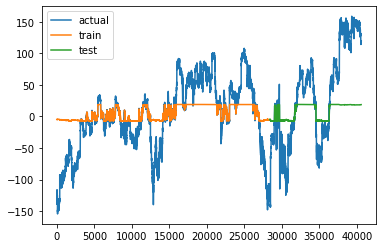

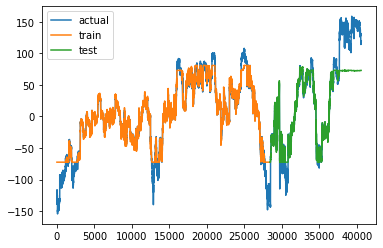

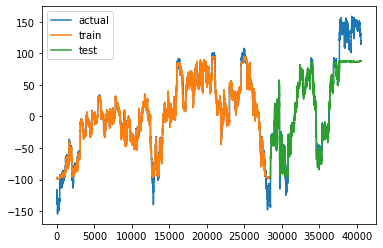

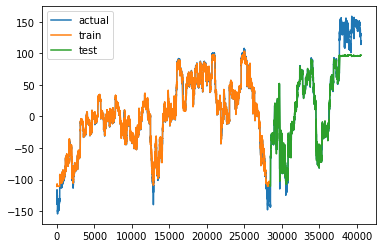

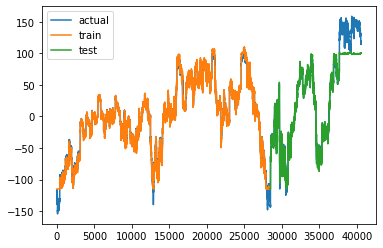

In [4]:
def Datafrme_Predictions(df_test,model):
	return Y_Prediction

def Predictions( train_size, T, X, Y_, batch_size, encoder,decoder,on_train = False):
	if on_train:
		Y_Prediction = numpy.zeros(train_size - T + 1)
	else:
		Y_Prediction = numpy.zeros(X.shape[0] - train_size)

	i = 0
	while i < len(Y_Prediction):
		batches = numpy.array(range(len(Y_Prediction)))[i : (i + batch_size)]
		x1 = numpy.zeros((len(batches), T - 1, X.shape[1]))
		y1 = numpy.zeros((len(batches), T - 1))
		for j in range(len(batches)):
			if on_train:
				x1[j, :, :] = X[range(batches[j], batches[j] + T - 1), :]
				y1[j, :] = Y_[range(batches[j],  batches[j]+ T - 1)]
			else:
				x1[j, :, :] = X[range(batches[j] + train_size - T, batches[j] + train_size - 1), :]
				y1[j, :] = Y_[range(batches[j] + train_size - T,  batches[j]+ train_size - 1)]

		y1 = Variable(torch.from_numpy(y1).type(torch.FloatTensor))
		_, input_encoded = encoder(Variable(torch.from_numpy(x1).type(torch.FloatTensor)))
		Y_Prediction[i:(i + batch_size)] = decoder(input_encoded, y1).cpu().data.numpy()[:, 0]

		i += batch_size
	return Y_Prediction

if __name__=='__main__':
	
	Final_Data_File = f'nasdaq100_padding.csv'
	Data_Frame = pandas.read_csv('nasdaq100_padding.csv') # data loading

	Label_Columns = 'NDX'		
	start = -1 * len(Data_Frame)
	end = None
	Data_Frame_partial = Data_Frame.iloc[start:end]
	# Window size
	window_size = 10
	label = Label_Columns
	Columns_X = [x1 for x1 in Data_Frame_partial.columns.tolist() if x1 != label]
	X = Data_Frame_partial.loc[:, Columns_X].values
	Y_ = numpy.array(Data_Frame_partial[label])
	# Batch size
	Data_Batch_Size =128 
	encoder_hidden_size = 64
	decoder_hidden_size = 64
	
	encoder = encoder(input_size = X.shape[1], 
	                  hidden_size = encoder_hidden_size, T = window_size)
	decoder = decoder(hidden_encode = encoder_hidden_size,
						   hidden_decode = decoder_hidden_size,T = window_size)

	encoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, encoder.parameters()),
									   lr = .001)
	decoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, decoder.parameters()),
									   lr = .001)
	Training_Size = int(X.shape[0] * 0.7)
	y_train_mean = numpy.mean(Y_[:Training_Size])
	Y_ = Y_ - y_train_mean
	# Epochs 
	Number_Epochs = 50

	Iters_Per_Epochs = int(numpy.ceil(Training_Size * 1. / Data_Batch_Size))
	Iters_Loses = numpy.zeros(Number_Epochs* Iters_Per_Epochs)
	Epoches_Loses = numpy.zeros(Number_Epochs)
	
	# loss function
	Loss_Function = T_NN.MSELoss()

	for j in range(Number_Epochs):
		Perms_Ids = numpy.random.permutation(Training_Size - window_size)
		k = 0
		while k < Training_Size:

			batcheid = Perms_Ids[j:min(k + Data_Batch_Size,len(Perms_Ids))]
			X1_ = numpy.zeros((len(batcheid), window_size - 1, X.shape[1]))
			prev_y1 = numpy.zeros((len(batcheid), window_size - 1))
			target_y = Y_[batcheid + window_size]

			for l in range(len(batcheid)):
				X1_[l, :, :] = X[batcheid[l] : (batcheid[l] + window_size - 1), :]
				prev_y1[l, :] = Y_[batcheid[l] : (batcheid[l] + window_size - 1)]
			encoder_optimizer.zero_grad()
			decoder_optimizer.zero_grad()

			Weight_Input, input_encoded = encoder(Variable(torch.from_numpy(X1_).type(torch.FloatTensor)))
			y_pred = decoder(input_encoded, Variable(torch.from_numpy(prev_y1).type(torch.FloatTensor)))
			y_actual = Variable(torch.from_numpy(target_y).type(torch.FloatTensor)).reshape(target_y.shape[0],1)

			# Taking the Root of our MSE loss and finding the RMSE
			Loses = torch.sqrt(Loss_Function(y_pred, y_actual))
			Loses.backward() 

			encoder_optimizer.step()
			decoder_optimizer.step()

			if len(Loses.data.shape)>0:
				Loses=Loses.data[0]
			Loses = Loses.data.reshape((-1,1)[0])

			Iters_Loses[int(j * Iters_Per_Epochs + k / Data_Batch_Size)] = Loses
			k += Data_Batch_Size

		Epoches_Loses[j] = numpy.mean(Iters_Loses[range(j * Iters_Per_Epochs, (j + 1) * Iters_Per_Epochs)])
	
    # Plotting graphs after every 10 epochs               
		if j % 10 == 0:
			y_train_pred = Predictions( Training_Size, window_size, X, Y_, Data_Batch_Size, encoder,decoder,on_train=True)
			y_test_pred = Predictions(Training_Size, window_size, X, Y_, Data_Batch_Size, encoder,decoder,on_train = False)
			Y_Prediction = numpy.concatenate((y_train_pred, y_test_pred))
			PLT.figure()
			PLT.plot(range(1, 1 + len(Y_)), Y_, label = "actual")
			PLT.plot(range(window_size , len(y_train_pred) + window_size), y_train_pred, label = 'train')
			PLT.plot(range(window_size + len(y_train_pred) , len(Y_) + 1), y_test_pred, label = 'test')
			PLT.legend(loc = 'best')
			PLT.show()

	Y_Prediction = Predictions( Training_Size, window_size, X, Y_, Data_Batch_Size, encoder,decoder)
	predict = Y_Prediction

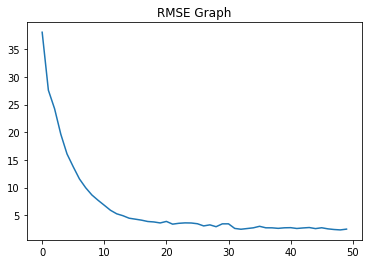

In [5]:
# Plot for the RMSE graph
PLT.figure()
PLT.plot(range(len(Epoches_Loses)), Epoches_Loses)
PLT.title('RMSE Graph')
PLT.show()

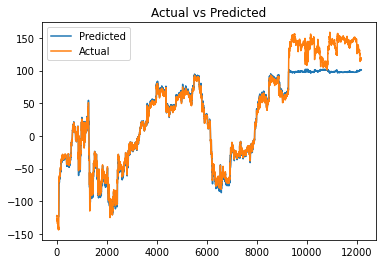

In [6]:
# Actual vs Predicted for test set
PLT.figure()
PLT.plot(predict, label = 'Predicted')
PLT.plot(Y_[Training_Size:], label = "Actual")
PLT.title('Actual vs Predicted')
PLT.legend(loc = 'best')
PLT.show()